<a href="https://colab.research.google.com/github/ivinitus/Cashflow-forecasting/blob/main/COLAB/lstm_finalll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
21/21 [==============================] - 12s 130ms/step - loss: 0.1124 - val_loss: 0.1094
Epoch 2/100
21/21 [==============================] - 1s 48ms/step - loss: 0.1122 - val_loss: 0.1101
Epoch 3/100
21/21 [==============================] - 1s 47ms/step - loss: 0.1128 - val_loss: 0.1117
Epoch 4/100
21/21 [==============================] - 1s 56ms/step - loss: 0.1122 - val_loss: 0.1100
Epoch 5/100
21/21 [==============================] - 2s 91ms/step - loss: 0.1119 - val_loss: 0.1113
Epoch 6/100
21/21 [==============================] - 2s 82ms/step - loss: 0.1120 - val_loss: 0.1100
Epoch 7/100
21/21 [==============================] - 1s 47ms/step - loss: 0.1116 - val_loss: 0.1102
Epoch 8/100
21/21 [==============================] - 1s 48ms/step - loss: 0.1125 - val_loss: 0.1111
Epoch 9/100
21/21 [==============================] - 1s 48ms/step - loss: 0.1115 - val_loss: 0.1099
Epoch 10/100
21/21 [==============================] - 1s 47ms/step - loss: 0.1114 - val_loss: 0.11

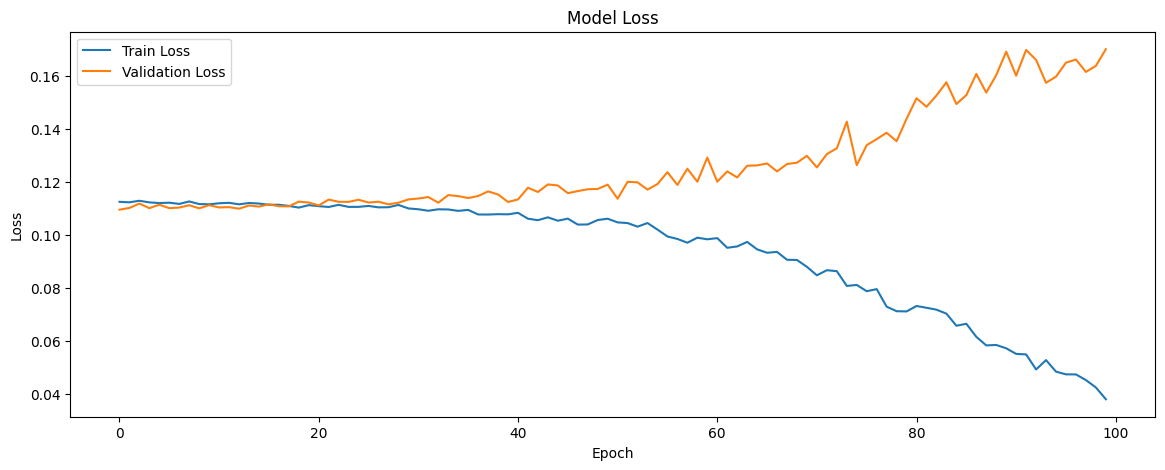

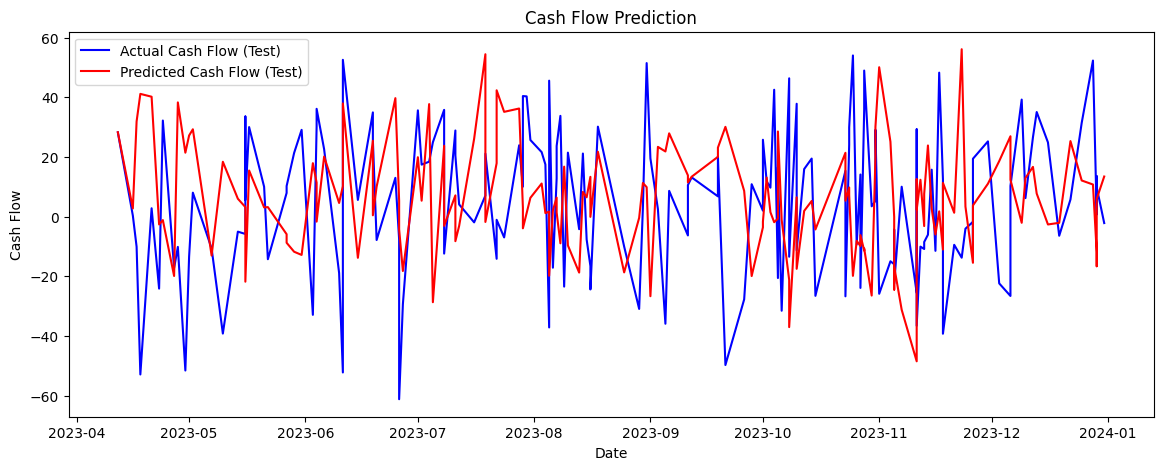

1/1 [==============================] - 0s 26ms/step
Predicted cash flow for the next month: 26.861267


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Load and preprocess the dataset
def load_and_preprocess_data(file_path, target_column):
    data = pd.read_excel(file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
    data.set_index('Date', inplace=True)
    return data

# Scaling the target column
def scale_data(data, target_column):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data[[target_column]])
    return scaled_data, scaler

# Create sequences from the data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Build and compile the LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(100, return_sequences=True, input_shape=input_shape)),
        Dropout(0.2),
        Bidirectional(LSTM(100, return_sequences=False)),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(14, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Plot actual vs predicted values
def plot_predictions(data_index, y_test, predicted):
    plt.figure(figsize=(14, 5))
    plt.plot(data_index, y_test, color='blue', label='Actual Cash Flow (Test)')
    plt.plot(data_index, predicted, color='red', label='Predicted Cash Flow (Test)')
    plt.title('Cash Flow Prediction')
    plt.xlabel('Date')
    plt.ylabel('Cash Flow')
    plt.legend()
    plt.show()

# Main function
def main():
    # Constants
    FILE_PATH = 'cash_flow_data_ final.xlsx'
    TARGET_COLUMN = 'Cash Flow'
    SEQ_LENGTH = 12

    # Load and preprocess the data
    data = load_and_preprocess_data(FILE_PATH, TARGET_COLUMN)

    # Scale the target column
    scaled_cash_flow, scaler_cash_flow = scale_data(data, TARGET_COLUMN)

    # Create sequences
    X, y = create_sequences(scaled_cash_flow, SEQ_LENGTH)

    # Reshape X for LSTM
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split data into training and testing datasets using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # Build the LSTM model
    model = build_lstm_model((SEQ_LENGTH, 1))

    # Train the LSTM model
    history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

    # Evaluate the model
    predicted = model.predict(X_test)
    predicted_cash_flow = scaler_cash_flow.inverse_transform(predicted)
    y_test_unscaled = scaler_cash_flow.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_unscaled, predicted_cash_flow))
    mae = mean_absolute_error(y_test_unscaled, predicted_cash_flow)
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    # Plot training & validation loss
    plot_training_history(history)

    # Plot actual vs predicted cash flow
    plot_predictions(data.index[SEQ_LENGTH:][len(train_index):], y_test_unscaled, predicted_cash_flow)

    # Predict future cash flows
    last_sequence = scaled_cash_flow[-SEQ_LENGTH:]
    last_sequence = last_sequence.reshape((1, SEQ_LENGTH, 1))

    next_month_prediction = model.predict(last_sequence)
    next_month_prediction_cash_flow = scaler_cash_flow.inverse_transform(next_month_prediction.reshape(-1, 1))

    print("Predicted cash flow for the next month:", next_month_prediction_cash_flow[0][0])

if __name__ == "__main__":
    main()
